In [1]:
import torch
from scipy.optimize import brentq,root_scalar
import scipy.stats as st
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
corruptions = ['gaussian_noise','impulse_noise','shot_noise','defocus_blur','glass_blur','motion_blur','zoom_blur','snow','frost','fog','brightness','contrast','elastic_transform','jpeg_compression','pixelate']
# load the confidence scores
clean_embds_S,clean_labels_S,clean_preds_S = torch.load("../continual_learning/continual_learning_playground/src/test_time_kd/embds/mnv3small_clean224.pt")
clean_embds_T,clean_labels_T,clean_preds_T = torch.load("../continual_learning/continual_learning_playground/src/test_time_kd/embds/resnet50_clean224.pt")
corr_embds_T = []
corr_labels_T = []
corr_preds_T = []
corr_embds_S = []
corr_labels_S = []
corr_preds_S = []
# corr_embds64 = []
# corr_labels64 = []
# corr_preds64 = []
for i,corr in enumerate(corruptions):
    e_S,l_S,p_S = torch.load("../continual_learning/continual_learning_playground/src/test_time_kd/embds/sev3_mnv3small_corr224_"+corr+".pt")
    e_T,l_T,p_T = torch.load("../continual_learning/continual_learning_playground/src/test_time_kd/embds/sev3_resnet50_corr224_"+corr+".pt")
    # e64,l64,p64 = torch.load("embds/corr64_"+corr+".pt")
    corr_embds_T.append(e_T)
    corr_labels_T.append(l_T)
    corr_preds_T.append(p_T)
    corr_embds_S.append(e_S)
    corr_labels_S.append(l_S)
    corr_preds_S.append(p_S)

0

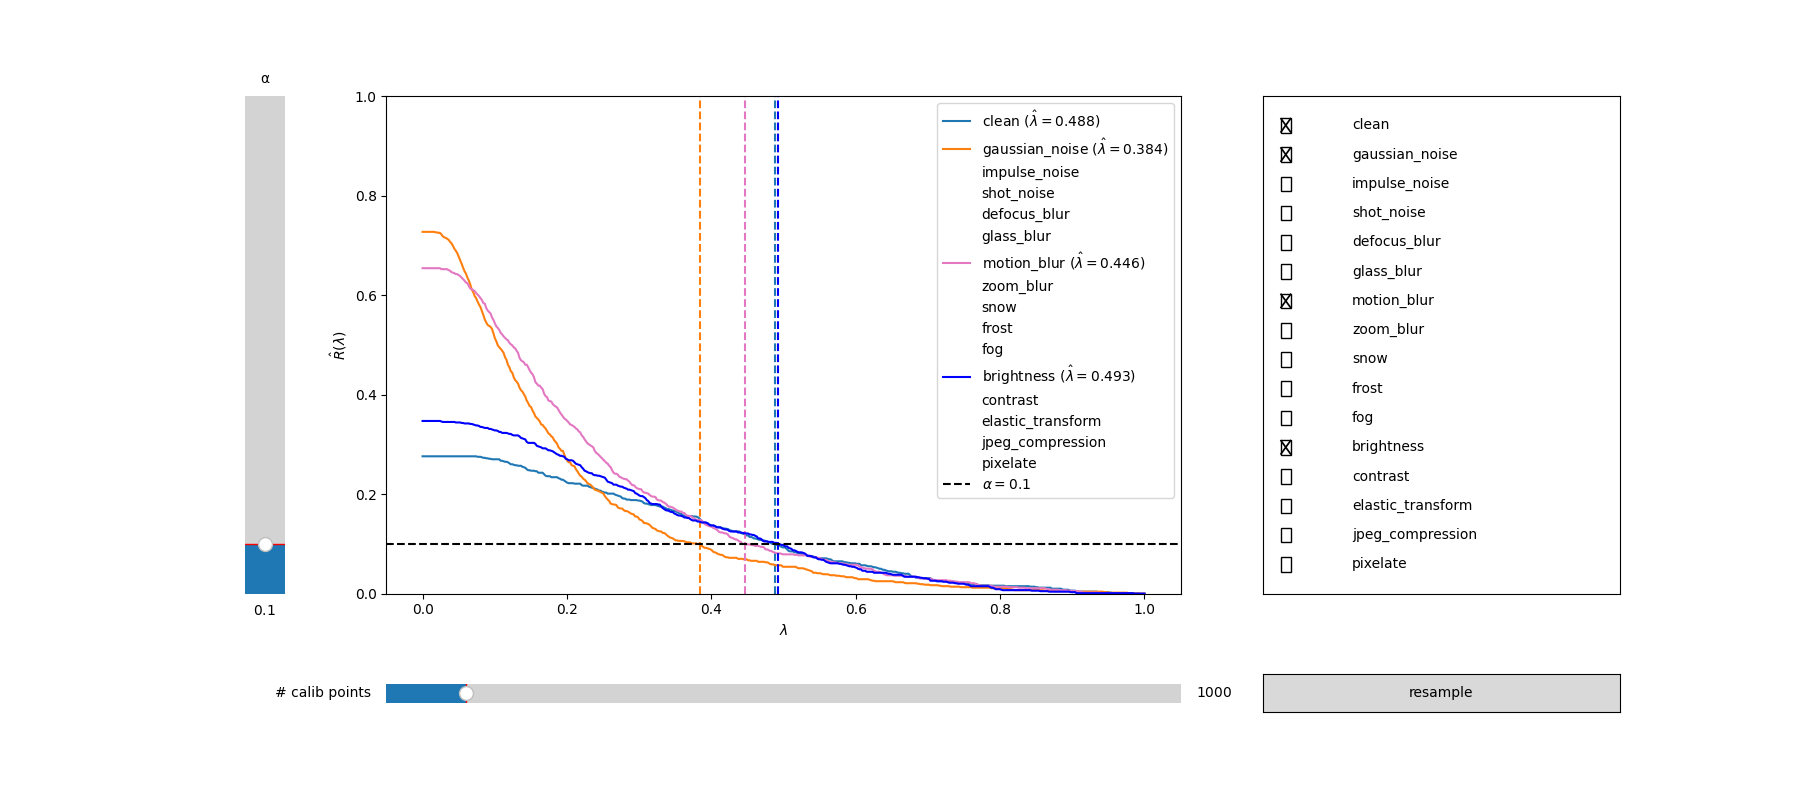

In [3]:
%matplotlib widget

from matplotlib.widgets import Slider, Button, RadioButtons,CheckButtons
# plot risk for different lambdas
import matplotlib.pyplot as plt
import numpy as np

fig,axs = plt.subplot_mosaic([['alpha','risk_curves','curve_selection'],
                              ['alpha','risk_curves','curve_selection'],
                              ['alpha','risk_curves','curve_selection'],
                              ['space','space','space'],
                              ['none','num_calib','resample']],figsize=(18,8),
                              gridspec_kw={'width_ratios':[0.1,1,0.45],
                                           'height_ratios': [1,1,1,0.25,0.25]})

# initialize widgets
alpha = Slider(axs['alpha'], 'α', 0, 1.0, valinit=0.1,orientation="vertical")
num_calib = Slider(axs['num_calib'], '# calib points', 0, 10000, valinit=1000,valstep=1,orientation="horizontal")
resample = Button(axs['resample'], 'resample')

axs['none'].axis('off')
axs['space'].axis('off')
# axs['curve_selection'].axis('off')
# axs['resample'].axis('off')

# static variables
curves = [None,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
curve_labels = ["clean"] + corruptions

confs = []
decs_S = []
decs_T = []


for curve in curves:
    if curve != None:
        student_confs,student_decs = torch.max(corr_preds_S[curve],dim=1)
        teacher_confs,teacher_decs = torch.max(corr_preds_T[curve],dim=1)
    else:
        student_confs,student_decs = torch.max(clean_preds_S,dim=1)
        teacher_confs,teacher_decs = torch.max(clean_preds_T,dim=1)
    confs.append(student_confs)
    decs_S.append(student_decs)
    decs_T.append(teacher_decs)

lams = np.linspace(0,1,500)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
cycle.extend(['k','b','lime','coral','khaki','deeppink'])

# gt_vals = corr_labels_T[0]


# dynamic variables, start with these initial conditions
torch.manual_seed(0)
rand_idxs = torch.randperm(50000)
cal_idxs = rand_idxs[:num_calib.val]
# val_idxs = rand_idxs[num_calib.val:]

cal_scores = []
cal_preds_S = []
cal_preds_T = []
# val_scores = []
# val_preds_S = []
# val_preds_T = []

init_curves = [None,0,5,10]

for i,curve in enumerate(curves):
    cal_scores.append(confs[i][cal_idxs])
    cal_preds_S.append(decs_S[i][cal_idxs])
    cal_preds_T.append(decs_T[i][cal_idxs])
    # val_scores.append(confs[i][val_idxs])
    # val_preds_S.append(decs_S[i][val_idxs])
    # val_preds_T.append(decs_T[i][val_idxs])

y = [[] for i in range(len(curves))]
lam_threshs = [[] for i in range(len(curves))]
lam_hats = []
# accs = [[] for i in range(len(curves))]

for i,curve in enumerate(curves):
    def zo_loss(p_pred_set,t_pred_set):
        return (p_pred_set != t_pred_set).float().mean()
    def lamhat_threshold(lam): 
        p_set = (cal_scores[i] >= lam)*cal_preds_S[i] + (cal_scores[i] < lam)*cal_preds_T[i]
        return zo_loss(p_set, cal_preds_T[i]) - ((num_calib.val+1)/num_calib.val*alpha.val - 1/(num_calib.val+1)) # why is this over n+1???

    for lam in lams:
        # cal
        p_set = (cal_scores[i] >= lam)*cal_preds_S[i] + (cal_scores[i] < lam)*cal_preds_T[i]
        y[i].append((p_set != cal_preds_T[i]).float().mean())

        # val
        # p_set = (val_scores[i] >= lam)*val_preds_S[i] + (val_scores[i] < lam)*val_preds_T[i]
        # accs[i].append((p_set == gt_vals[val_idxs]).float().mean())
    
    if lamhat_threshold(0) <= 0 and lamhat_threshold(1) <= 0:
        lamhat = max(lamhat_threshold(0),lamhat_threshold(1),0)
    elif lamhat_threshold(0) >= 0 and lamhat_threshold(1) >= 0:
        lamhat = max(lamhat_threshold(0),lamhat_threshold(1),1)
    else:
        lamhat = brentq(lamhat_threshold, 0, 1)
    lam_hats.append(lamhat)
 

risk_lines = []
lambda_lines = []
# acc_lines = []
for i,curve in enumerate(curves):
    if curve == None:
        l, = axs['risk_curves'].plot(lams,y[i],label="clean",c=cycle[i],visible=False)
        # a, = axs['acc_curves'].plot(lams,accs[i],label="clean",c=cycle[i],visible=False)
        risk_lines.append(l)
        # acc_lines.append(a)
    else:
        l, = axs['risk_curves'].plot(lams,y[i],label=corruptions[curve],c=cycle[i],visible=False)
        # a, = axs['acc_curves'].plot(lams,accs[i],label=corruptions[curve],c=cycle[i],visible=False)
        risk_lines.append(l)
        # acc_lines.append(a)
    l = axs['risk_curves'].axvline(lam_hats[i],linestyle="--",c=cycle[i],visible=False)
    lambda_lines.append(l)

    if curve in init_curves:
        risk_lines[i].set_visible(True)
        # acc_lines[i].set_visible(True)
        try:
            risk_lines[i].set_label(curve_labels[i]+r" $(\hat{\lambda}=$"+str(round(lambda_lines[i].get_data()[0][0],3))+")")
        except:
            risk_lines[i].set_label(curve_labels[i]+r" $(\hat{\lambda}=$"+str(round(lambda_lines[i].get_data()[0],3))+")")
        # acc_lines[i].set_label(curve_labels[i]+r" $(\hat{\lambda}=$"+str(round(lambda_lines[i].get_data()[0][0],3))+")")
        lambda_lines[i].set_visible(True)
alpha_line = axs['risk_curves'].axhline(alpha.val,c="k",linestyle="--",label=r"$\alpha = 0.1$")
axs['risk_curves'].set_xlabel("$\lambda$")
axs['risk_curves'].set_ylabel("$\hat{R}(\lambda)$")
axs['risk_curves'].legend()
axs['risk_curves'].set_ylim([0,1])
# axs['acc_curves'].set_xlabel("$\lambda$")
# axs['acc_curves'].set_ylabel("$Accuracy$")
# axs['acc_curves'].legend()
# axs['acc_curves'].set_ylim([0,1])

check = CheckButtons(
    ax=axs['curve_selection'],
    labels=curve_labels,
    actives=[l.get_visible() for l in risk_lines],
    # label_props={'color': cycle},
    # frame_props={'edgecolor': cycle},
    # check_props={'facecolor': cycle},
)


def alpha_update(val):
    # update the calculation for lamhat
    for i,curve in enumerate(curves):
        def zo_loss(p_pred_set,t_pred_set):
            return (p_pred_set != t_pred_set).float().mean()
        def lamhat_threshold(lam): 
            p_set = (cal_scores[i] >= lam)*cal_preds_S[i] + (cal_scores[i] < lam)*cal_preds_T[i]
            return zo_loss(p_set, cal_preds_T[i]) - ((num_calib.val+1)/num_calib.val*alpha.val - 1/(num_calib.val+1)) # why is this over n+1???

        for j,lam in enumerate(lams):
            p_set = (cal_scores[i] >= lam)*cal_preds_S[i] + (cal_scores[i] < lam)*cal_preds_T[i]
            y[i][j] = (p_set != cal_preds_T[i]).float().mean()
            # p_set = (val_scores[i] >= lam)*val_preds_S[i] + (val_scores[i] < lam)*val_preds_T[i]
            # accs[i][j] = (p_set == gt_vals[val_idxs]).float().mean()
        
        if lamhat_threshold(0) <= 0 and lamhat_threshold(1) <= 0:
            lamhat = max(lamhat_threshold(0),lamhat_threshold(1),0)
        elif lamhat_threshold(0) >= 0 and lamhat_threshold(1) >= 0:
            lamhat = max(lamhat_threshold(0),lamhat_threshold(1),1)
        else:
            lamhat = brentq(lamhat_threshold, 0, 1)
        lam_hats[i] = lamhat

        lambda_lines[i].set(xdata=lam_hats[i])
        alpha_line.set(ydata=alpha.val,label=r"$\alpha =$"+str(round(alpha.val,3)))
        # acc_lines[i].set(ydata=accs[i])
        if risk_lines[i].get_visible():
            # print(lambda_lines[i].get_data()[0])
            try:
                risk_lines[i].set_label(curve_labels[i]+r" $(\hat{\lambda}=$"+str(round(lambda_lines[i].get_data()[0],3))+")")
            except:
                risk_lines[i].set_label(curve_labels[i]+r" $(\hat{\lambda}=$"+str(round(lambda_lines[i].get_data()[0][0],3))+")")
        axs['risk_curves'].legend()

alpha.on_changed(alpha_update)

def curve_update(label):
    
    risk_line = risk_lines[curve_labels.index(label)]
    lambda_line = lambda_lines[curve_labels.index(label)]
    # acc_line = acc_lines[curve_labels.index(label)]
    
    risk_line.set_visible(not risk_line.get_visible())
    lambda_line.set_visible(not lambda_line.get_visible())
    # acc_line.set_visible(not acc_line.get_visible())
    risk_line.figure.canvas.draw_idle()
    lambda_line.figure.canvas.draw_idle()
    # acc_line.figure.canvas.draw_idle()
    if risk_line.get_visible():
        # print(lambda_lines[i].get_data()[0])
        try:
            risk_line.set_label(label+r" $(\hat{\lambda}=$"+str(round(lambda_line.get_data()[0],3))+")")
        except:
            risk_line.set_label(label+r" $(\hat{\lambda}=$"+str(round(lambda_line.get_data()[0][0],3))+")")
    else:
        risk_line.set_label(label)
    
    axs['risk_curves'].legend()

check.on_clicked(curve_update)


def num_calib_update(val):
    cal_idxs = rand_idxs[:num_calib.val]
    # val_idxs = rand_idxs[num_calib.val:]

    cal_scores = []
    cal_preds_S = []
    cal_preds_T = []
    # val_scores = []
    # val_preds_S = []
    # val_preds_T = []

    init_curves = [None,0,5,10]

    for i,curve in enumerate(curves):
        cal_scores.append(confs[i][cal_idxs])
        cal_preds_S.append(decs_S[i][cal_idxs])
        cal_preds_T.append(decs_T[i][cal_idxs])
        # val_scores.append(confs[i][val_idxs])
        # val_preds_S.append(decs_S[i][val_idxs])
        # val_preds_T.append(decs_T[i][val_idxs])


    # update the calculation for lamhat
    for i,curve in enumerate(curves):
        def zo_loss(p_pred_set,t_pred_set):
            return (p_pred_set != t_pred_set).float().mean()
        def lamhat_threshold(lam): 
            p_set = (cal_scores[i] >= lam)*cal_preds_S[i] + (cal_scores[i] < lam)*cal_preds_T[i]
            return zo_loss(p_set, cal_preds_T[i]) - ((num_calib.val+1)/num_calib.val*alpha.val - 1/(num_calib.val+1)) # why is this over n+1???

        for j,lam in enumerate(lams):
            p_set = (cal_scores[i] >= lam)*cal_preds_S[i] + (cal_scores[i] < lam)*cal_preds_T[i]
            y[i][j] = (p_set != cal_preds_T[i]).float().mean()
            # p_set = (val_scores[i] >= lam)*val_preds_S[i] + (val_scores[i] < lam)*val_preds_T[i]
            # accs[i][j] = (p_set == gt_vals[val_idxs]).float().mean()
        
        if lamhat_threshold(0) <= 0 and lamhat_threshold(1) <= 0:
            lamhat = max(lamhat_threshold(0),lamhat_threshold(1),0)
        elif lamhat_threshold(0) >= 0 and lamhat_threshold(1) >= 0:
            lamhat = max(lamhat_threshold(0),lamhat_threshold(1),1)
        else:
            lamhat = brentq(lamhat_threshold, 0, 1)
        lam_hats[i] = lamhat

        lambda_lines[i].set(xdata=lam_hats[i])
        risk_lines[i].set(ydata=y[i])
        # acc_lines[i].set(ydata=accs[i])
        alpha_line.set(ydata=alpha.val,label=r"$\alpha =$"+str(round(alpha.val,3)))
        if risk_lines[i].get_visible():
            # print(lambda_lines[i].get_data()[0])
            try:
                risk_lines[i].set_label(curve_labels[i]+r" $(\hat{\lambda}=$"+str(round(lambda_lines[i].get_data()[0],3))+")")
            except:
                risk_lines[i].set_label(curve_labels[i]+r" $(\hat{\lambda}=$"+str(round(lambda_lines[i].get_data()[0][0],3))+")")
        else:
            risk_lines[i].set_label(curve_labels[i])
        axs['risk_curves'].legend()

num_calib.on_changed(num_calib_update)


def resample_update(val):
    rand_idxs = torch.randperm(50000)
    cal_idxs = rand_idxs[:num_calib.val]
    # val_idxs = rand_idxs[num_calib.val:]

    cal_scores = []
    cal_preds_S = []
    cal_preds_T = []
    # val_scores = []
    # val_preds_S = []
    # val_preds_T = []

    init_curves = [None,0,5,10]

    for i,curve in enumerate(curves):
        cal_scores.append(confs[i][cal_idxs])
        cal_preds_S.append(decs_S[i][cal_idxs])
        cal_preds_T.append(decs_T[i][cal_idxs])
        # val_scores.append(confs[i][val_idxs])
        # val_preds_S.append(decs_S[i][val_idxs])
        # val_preds_T.append(decs_T[i][val_idxs])


    # update the calculation for lamhat
    for i,curve in enumerate(curves):
        def zo_loss(p_pred_set,t_pred_set):
            return (p_pred_set != t_pred_set).float().mean()
        def lamhat_threshold(lam): 
            p_set = (cal_scores[i] >= lam)*cal_preds_S[i] + (cal_scores[i] < lam)*cal_preds_T[i]
            return zo_loss(p_set, cal_preds_T[i]) - ((num_calib.val+1)/num_calib.val*alpha.val - 1/(num_calib.val+1)) # why is this over n+1???

        for j,lam in enumerate(lams):
            p_set = (cal_scores[i] >= lam)*cal_preds_S[i] + (cal_scores[i] < lam)*cal_preds_T[i]
            y[i][j] = (p_set != cal_preds_T[i]).float().mean()
            # p_set = (val_scores[i] >= lam)*val_preds_S[i] + (val_scores[i] < lam)*val_preds_T[i]
            # accs[i][j] = (p_set == gt_vals[val_idxs]).float().mean()
        
        if lamhat_threshold(0) <= 0 and lamhat_threshold(1) <= 0:
            lamhat = max(lamhat_threshold(0),lamhat_threshold(1),0)
        elif lamhat_threshold(0) >= 0 and lamhat_threshold(1) >= 0:
            lamhat = max(lamhat_threshold(0),lamhat_threshold(1),1)
        else:
            lamhat = brentq(lamhat_threshold, 0, 1)
        lam_hats[i] = lamhat

        lambda_lines[i].set(xdata=lam_hats[i])
        risk_lines[i].set(ydata=y[i])
        # acc_lines[i].set(ydata=accs[i])
        alpha_line.set(ydata=alpha.val,label=r"$\alpha =$"+str(round(alpha.val,3)))
        if risk_lines[i].get_visible():
            # print(lambda_lines[i].get_data()[0])
            try:
                risk_lines[i].set_label(curve_labels[i]+r" $(\hat{\lambda}=$"+str(round(lambda_lines[i].get_data()[0],3))+")")
            except:
                risk_lines[i].set_label(curve_labels[i]+r" $(\hat{\lambda}=$"+str(round(lambda_lines[i].get_data()[0][0],3))+")")
        else:
            risk_lines[i].set_label(curve_labels[i])
        axs['risk_curves'].legend()

resample.on_clicked(resample_update)